In [ ]:
# Install all packages
# Restart runtime after installation

#!wget https://github.com/PranjalSahu/ITKThinShellDemons/raw/pranjal_setup/itk_thinshelldemons-0.1.1-cp38-cp38m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
#!pip install itk_thinshelldemons-0.1.1-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
!pip install itk_thinshelldemons-0.1.1-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
!pip install itk==5.3rc4
!pip install vtk
!pip install itkwidgets

In [1]:
# Import all packages

import numpy as np
#import itkConfig
#itkConfig.LazyLoading = False
import itk
import vtk
import itkwidgets
import math
import matplotlib.pyplot as plt

from joblib import Parallel, delayed
import time
import copy

from vtk.util import numpy_support
from vtk.util.numpy_support import numpy_to_vtk
# To enable itkwidgets window
#from google.colab import output
#output.enable_custom_widget_manager()

In [2]:
# Helper Functions

def subsample_points(inputmesh, mesh_sub_sample_points, seed):
    import vtk
    from vtk.util import numpy_support

    sample = vtk.vtkPolyDataPointSampler()
    sample.SetInputData(inputmesh)
    sample.SetGenerateEdgePoints(0)
    sample.SetGenerateInteriorPoints(0)
    sample.SetPointGenerationModeToRegular()
    sample.SetDistance(0.5)
    sample.Update()

    sampled_points = sample.GetOutput()

    points = sampled_points.GetPoints()
    pointdata = points.GetData()

    as_numpy = numpy_support.vtk_to_numpy(pointdata)
    
    np.random.seed(seed)
    random_indices = np.random.choice(as_numpy.shape[0],
                                      size=mesh_sub_sample_points,
                                      replace=False)
    as_numpy_sampled = as_numpy[random_indices, :]

    return as_numpy_sampled

def subsample_points_poisson(inputMesh):
    import vtk
    from vtk.util import numpy_support

    f = vtk.vtkPoissonDiskSampler()
    f.SetInputData(inputMesh)
    f.SetRadius(4.5)
    f.Update()
    
    sampled_points = f.GetOutput()
    points = sampled_points.GetPoints()
    pointdata = points.GetData()

    as_numpy = numpy_support.vtk_to_numpy(pointdata)
    
    return as_numpy

def readvtk(filename):
    a = vtk.vtkPolyDataReader()
    a.SetFileName(filename)
    a.Update()
    m1 = a.GetOutput()
    return m1

def readply(filename):
    a = vtk.vtkPLYReader()
    a.SetFileName(filename)
    a.Update()
    m1 = a.GetOutput()
    return m1

#MOVING_MESH_FILE = '/data/Apedata/CorrectData/data/Pan/meshes/USNM220065-Cranium_merged_1.ply'
#FIXED_MESH_FILE  = '/data/Apedata/CorrectData/data/Gorilla/meshes/USNM252575-Cranium.ply'

# ransac registered
MOVING_MESH_FILE = '/home/pranjal.sahu/Documents/SampleApeData/USNM174722-Cranium_1.ply'
# original mesh
#MOVING_MESH_FILE = '/home/pranjal.sahu/Documents/SampleApeData/USNM174722-Cranium.ply'

FIXED_MESH_FILE  = '/home/pranjal.sahu/Documents/SampleApeData/USNM174701-Cranium_merged_1.ply'

paths = [FIXED_MESH_FILE, MOVING_MESH_FILE]

In [19]:
# Fetch the files

FIXED_MESH_FILE  = r'data/129S1_SVIMJ_.ply'
MOVING_MESH_FILE = r'data/129X1_SVJ_.ply'
paths = [FIXED_MESH_FILE, MOVING_MESH_FILE]

import os
import importlib
from urllib.request import urlretrieve

# Download meshes
os.makedirs('data',exist_ok=True)
if not os.path.exists(FIXED_MESH_FILE):
    url = 'https://github.com/SlicerMorph/Mouse_Models/raw/main/Models/129S1_SVIMJ_.ply'
    urlretrieve(url, FIXED_MESH_FILE)
if not os.path.exists(MOVING_MESH_FILE):
    url = 'https://github.com/SlicerMorph/Mouse_Models/raw/main/Models/129X1_SVJ_.ply'
    urlretrieve(url, MOVING_MESH_FILE)

In [75]:
# Clean the meshes and Triangulate them as TSD only works with Triangle Meshes

vtk_meshes = list()

for path in paths:
    reader = vtk.vtkPLYReader()
    reader.SetFileName(path)
    reader.Update()
        
    cleaner = vtk.vtkCleanPolyData()
    cleaner.SetInputData(reader.GetOutput())
    cleaner.ConvertLinesToPointsOn()
    cleaner.ConvertPolysToLinesOff()
    cleaner.SetTolerance(0.0)
    cleaner.Update()
    vtk_mesh = cleaner.GetOutput()

    triangle_filter = vtk.vtkTriangleFilter()
    triangle_filter.SetInputData(vtk_mesh)
    triangle_filter.SetPassLines(False)
    triangle_filter.SetPassVerts(False)
    triangle_filter.Update()
    vtk_mesh = triangle_filter.GetOutput()
    
    vtk_meshes.append(vtk_mesh)
    
# Write back out to a filetype supported by ITK
vtk_paths = [path.strip('.ply') + '.vtk' for path in paths]
for idx, mesh in enumerate(vtk_meshes):
    writer = vtk.vtkPolyDataWriter()
    writer.SetInputData(mesh)
    writer.SetFileVersion(42)
    writer.SetFileTypeToBinary()
    writer.SetFileName(vtk_paths[idx])
    writer.Update()
    
itk_meshes = [itk.meshread(path, pixel_type=itk.D) for path in vtk_paths]

In [76]:
# Convert meshes to images for performing moment based initialization

itk_transformed_meshes= []
# itk_meshes = []
# itk_meshes.append(itk.meshread('itk_meshes_0.vtk'))
# itk_meshes.append(itk.meshread('itk_meshes_1.vtk'))

itk_images = []
for mesh in itk_meshes:
    # Get all the points to positive values
    temp = itk.array_from_vector_container(mesh.GetPoints())
    m    = np.min(temp, 0)
    temp = temp - m
    mesh.SetPoints(itk.vector_container_from_array(temp.flatten())) 
    
    itk_transformed_meshes.append(mesh)
    itk_image = itk.triangle_mesh_to_binary_image_filter(mesh,
                                                      origin=[0, 0, 0],
                                                      spacing=[1, 1, 1],
                                                      size=[250, 250, 250])
    itk_images.append(itk_image)
                                                         

itk_transforms = list()

for image in itk_images:
    calculator = itk.ImageMomentsCalculator[type(image)].New()
    calculator.SetImage(image)
    calculator.Compute()
    itk_transforms.append(calculator.GetPhysicalAxesToPrincipalAxesTransform())

In [77]:
# Write the Moment based initialized meshes as vtk file

itk_transformed_meshes = [
    itk.transform_mesh_filter(mesh, transform=itk_transforms[idx])
    for idx, mesh in enumerate(itk_meshes)
]

fixedMesh  = itk_meshes[0]#itk_transformed_meshes[0]
movingMesh = itk_meshes[1]#itk_transformed_meshes[1]


w1 = itk.MeshFileWriter[type(movingMesh)].New()
w1.SetFileName('movingMesh.vtk')
w1.SetFileTypeAsBINARY()
w1.SetInput(movingMesh)
w1.Update()

w1 = itk.MeshFileWriter[type(movingMesh)].New()
w1.SetFileName('fixedMesh.vtk')
w1.SetFileTypeAsBINARY()
w1.SetInput(fixedMesh)
w1.Update()

#itk.meshwrite(movingMesh, 'movingMesh.vtk')
#itk.meshwrite(fixedMesh, 'fixedMesh.vtk')

In [15]:
vtk_data_array = numpy_support.numpy_to_vtk(num_array=as_numpy_sampled,
                                            deep=True,
                                            array_type=vtk.VTK_FLOAT)
points2 = vtk.vtkPoints()
points2.SetData(vtk_data_array)

In [16]:
poly1 = vtk.vtkPolyData()
poly1.SetPoints(points2)

In [24]:
print(as_numpy_sampled.shape)
print(as_numpy_sampled)

(10000, 3)
[[ -19.032843  -62.61089    59.35268 ]
 [-102.698235  -36.72439   102.16699 ]
 [ -62.66175  -118.70344   112.004196]
 ...
 [ -72.941345 -124.75717    79.54381 ]
 [ -48.884876  -20.545244   62.336174]
 [ -86.15137  -143.80577    69.43055 ]]


In [21]:
f = vtk.vtkDecimatePro()
f.SetTargetReduction(0.9)
f.SetInputData(m1)
f.Update()
m1d = f.GetOutput()

f = vtk.vtkDecimatePro()
f.SetTargetReduction(0.9)
f.SetInputData(m2)
f.Update()
m2d = f.GetOutput()

print(m1d.GetNumberOfPoints())
print(m2d.GetNumberOfPoints())

242246
439173


In [14]:
number_of_rows = 10000

random_indices = np.random.choice(as_numpy.shape[0], 
                                  size=number_of_rows, 
                                  replace=False)
as_numpy_sampled = as_numpy[random_indices, :]

print(as_numpy_sampled.shape)

(10000, 3)


In [ ]:
itkwidgets.view(geometries=[fixedMesh, movingMesh])

In [32]:
# Perform RANSAC ICP

def ransac_icp(fixedMesh, movingMesh, number_of_iterations, mesh_sub_sample_points, number_of_ransac_points, transform_type, convergance_value):
    all_points1 = itk.array_from_vector_container(movingMesh.GetPoints())
    all_points2 = itk.array_from_vector_container(fixedMesh.GetPoints())
    
    # Create Meshes with reduced number of points
    mesh_fixed  = itk.Mesh[itk.D, 3].New()
    mesh_moving = itk.Mesh[itk.D, 3].New()
    
    random_indices = np.random.choice(all_points1.shape[0], size=mesh_sub_sample_points)
    p1 = all_points1[random_indices, :]
    mesh_fixed.SetPoints(itk.vector_container_from_array(p1.flatten()))
    
    random_indices = np.random.choice(all_points2.shape[0], size=mesh_sub_sample_points)
    p2 = all_points2[random_indices, :]
    mesh_moving.SetPoints(itk.vector_container_from_array(p2.flatten()))
    
    best_score = 100000
    best_result = None
    best_transform = None
    
    if transform_type == 0:
        TransformType = itk.Euler3DTransform[itk.D]
    else:
        TransformType = itk.ScaleTransform[itk.D, 3]
    transform = TransformType.New()
    transform.SetIdentity()
    
    e_metric = itk.EuclideanDistancePointSetToPointSetMetricv4.PSD3.New()
    
    # For reproduciblity
    np.random.seed(5)
    for i in range(number_of_iterations):
        random_indices = np.random.choice(all_points1.shape[0], size=number_of_ransac_points)
        p1 = all_points1[random_indices, :]

        random_indices = np.random.choice(all_points2.shape[0], size=number_of_ransac_points)
        p2 = all_points2[random_indices, :]

        ps1 = itk.Mesh[itk.D, 3].New()
        ps2 = itk.Mesh[itk.D, 3].New()

        ps1.SetPoints(itk.vector_container_from_array(p1.flatten()))
        ps2.SetPoints(itk.vector_container_from_array(p2.flatten()))

        MetricType = itk.EuclideanDistancePointSetToPointSetMetricv4.PSD3
        metric = MetricType.New()
        metric.SetMovingPointSet(ps2)
        metric.SetFixedPointSet(ps1)
        metric.SetMovingTransform(transform)
        metric.Initialize()

        optimizer = itk.ConjugateGradientLineSearchOptimizerv4Template[itk.D].New()
        optimizer.SetNumberOfIterations(10)
        optimizer.SetMaximumStepSizeInPhysicalUnits( 0.1 )
        optimizer.SetMinimumConvergenceValue( 0.0 )
        optimizer.SetConvergenceWindowSize( 10 )
        optimizer.SetMetric(metric)
        optimizer.StartOptimization()

        current_transform    = metric.GetTransform()
        itk_transformed_mesh = itk.transform_mesh_filter(mesh_moving, transform=current_transform)

        e_metric.SetFixedPointSet(mesh_fixed)
        e_metric.SetMovingPointSet(itk_transformed_mesh)
        e_metric.Initialize()

        current_value = e_metric.GetValue()
        
        if current_value < best_score:
            best_score     = current_value
            best_result    = itk_transformed_mesh
            best_transform = current_transform

        if convergance_value > 0 and best_score < convergance_value:
            break
    
    print('Best Score ', best_score)
    itk_transformed_mesh = itk.transform_mesh_filter(movingMesh, transform=best_transform)
    return itk_transformed_mesh


#movingMesh = itk.meshread('/data/Apedata/apedata/apes/models/gorilla/USNM252577-Cranium.vtk')
#fixedMesh  = itk.meshread('/data/Apedata/apedata/apes/models/orangutan/USNM145303-Cranium.vtk')

movingMesh = itk.meshread('movingMesh.vtk')
fixedMesh  = itk.meshread('fixedMesh.vtk')

number_of_iterations    = 2000
number_of_ransac_points = 250
mesh_sub_sample_points  = 5000
convergence_value       = 6
transform_type          = 0

import time
start_time = time.time()
itk_transformed_mesh = ransac_icp(fixedMesh, movingMesh, number_of_iterations, mesh_sub_sample_points, number_of_ransac_points, transform_type, convergence_value)
itk.meshwrite(itk_transformed_mesh, 'ransacICPResult1.vtk')
end_time = time.time()

print(end_time - start_time)
# itk_transformed_mesh = itk.meshread('ransacICPResult1.vtk')
# number_of_iterations    = 100
# number_of_ransac_points = 1000
# mesh_sub_sample_points  = 20000
# convergence_value       = -1
# transform_type          = 0
# itk_transformed_mesh = ransac_icp(fixedMesh, itk_transformed_mesh, number_of_iterations, mesh_sub_sample_points, number_of_ransac_points, transform_type, convergence_value)
# itk.meshwrite(itk_transformed_mesh, 'ransacICPResult2.vtk')


# number_of_iterations    = 100
# number_of_ransac_points = 10000
# mesh_sub_sample_points  = 20000
# convergence_value       = -1
# transform_type          = 1
# itk_transformed_mesh = ransac_icp(fixedMesh, itk_transformed_mesh, number_of_iterations, mesh_sub_sample_points, number_of_ransac_points, transform_type, convergence_value)
# itk.meshwrite(itk_transformed_mesh, 'ransacICPResult3.vtk')

Best Score  13.128441318309916
65.535471200943


In [ ]:
# Perform Scale Transform

mesh_sub_sample_points = 10000

fixedMesh  = itk.meshread('fixedMesh.vtk', itk.D)
movingMesh = itk.meshread('movingMesh.vtk', itk.D)

ps1 = itk.Mesh[itk.D, 3].New()
ps2 = itk.Mesh[itk.D, 3].New()

all_points1 = itk.array_from_vector_container(fixedMesh.GetPoints())
all_points2 = itk.array_from_vector_container(movingMesh.GetPoints())

random_indices = np.random.choice(all_points1.shape[0], size=mesh_sub_sample_points)
p1 = all_points1[random_indices, :]

random_indices = np.random.choice(all_points2.shape[0], size=mesh_sub_sample_points)
p2 = all_points2[random_indices, :]

ps1.SetPoints(itk.vector_container_from_array(p1.flatten()))
ps2.SetPoints(itk.vector_container_from_array(p2.flatten()))


    
TransformType = itk.ScaleTransform[itk.D, 3]
        
transform = TransformType.New()
transform.SetIdentity()

MetricType = itk.EuclideanDistancePointSetToPointSetMetricv4.PSD3
metric = MetricType.New()
metric.SetMovingPointSet(movingMesh)
metric.SetFixedPointSet(fixedMesh)
metric.SetMovingTransform(transform)
metric.Initialize()

optimizer = itk.ConjugateGradientLineSearchOptimizerv4Template[itk.D].New()
optimizer.SetNumberOfIterations(10)
optimizer.SetMaximumStepSizeInPhysicalUnits( 0.1 )
optimizer.SetMinimumConvergenceValue( 0.0 )
optimizer.SetConvergenceWindowSize( 10 )
optimizer.SetMetric(metric)
optimizer.StartOptimization()

current_transform    = metric.GetTransform()
itk_transformed_mesh = itk.transform_mesh_filter(movingMesh, transform=current_transform)

In [8]:
# For performing RANSAC in parallel

from vtk.util import numpy_support
from vtk.util.numpy_support import numpy_to_vtk


def ransac_icp_parallel(fixedMeshPoints, movingMeshPoints, movingMeshAllPoints,
                        number_of_iterations, mesh_sub_sample_points,
                        number_of_ransac_points, transform_type,
                        convergance_value):
    import numpy as np
    np.random.seed(0)

    all_points1 = fixedMeshPoints
    all_points2 = movingMeshPoints

    def process(i, mesh_sub_sample_points, number_of_ransac_points,
                return_result):
        # Create Mesh inside the method to tackle the problem of serialization
        
        import itk
        
        mesh_fixed = itk.Mesh[itk.D, 3].New()
        mesh_moving = itk.Mesh[itk.D, 3].New()

        mesh_fixed.SetPoints(
            itk.vector_container_from_array(all_points1.flatten()))
        mesh_moving.SetPoints(
            itk.vector_container_from_array(all_points2.flatten()))

        ps1 = itk.Mesh[itk.D, 3].New()
        ps2 = itk.Mesh[itk.D, 3].New()
        
        
        # Create small point sets
        np.random.seed(i)
        random_indices = np.random.choice(all_points1.shape[0],
                                          size=number_of_ransac_points)
        p1_a = all_points1[random_indices, :]

        random_indices = np.random.choice(all_points2.shape[0],
                                          size=number_of_ransac_points)
        p2_a = all_points2[random_indices, :]

        ps1.SetPoints(itk.vector_container_from_array(p1_a.flatten()))
        ps2.SetPoints(itk.vector_container_from_array(p2_a.flatten()))

        if transform_type == 0:
            TransformType = itk.Euler3DTransform[itk.D]
        elif transform_type == 1:
            TransformType = itk.ScaleVersor3DTransform[itk.D]
        elif transform_type == 2:
            TransformType = itk.Similarity3DTransform[itk.D]
        else:
            TransformType = itk.AffineTransform[itk.D, 3]

        transform = TransformType.New()
        transform.SetIdentity()

        MetricType = itk.EuclideanDistancePointSetToPointSetMetricv4.PSD3
        metric = MetricType.New()
        metric.SetMovingPointSet(ps2)
        metric.SetFixedPointSet(ps1)
        metric.SetMovingTransform(transform)
        metric.Initialize()
                
        optimizer = itk.ConjugateGradientLineSearchOptimizerv4Template[itk.D].New()
        optimizer.SetNumberOfIterations(20)
        optimizer.SetMaximumStepSizeInPhysicalUnits( 0.1 )
        optimizer.SetMinimumConvergenceValue( 0.0 )
        optimizer.SetConvergenceWindowSize( 20 )
        optimizer.SetMetric(metric)
        optimizer.StartOptimization()

        """
        optimizer = itk.GradientDescentOptimizerv4Template.D.New()
        optimizer.SetNumberOfIterations(200)
        optimizer.SetLearningRate(0.1)
        optimizer.SetMaximumStepSizeInPhysicalUnits( 0.1 )
        optimizer.SetMinimumConvergenceValue( 0.0 )
        optimizer.SetConvergenceWindowSize( 200 )
        optimizer.SetMetric(metric)
        optimizer.StartOptimization()
        """
        
        current_transform = metric.GetTransform()
        itk_transformed_mesh = itk.transform_mesh_filter(
            mesh_moving, transform=current_transform)

        e_metric = itk.EuclideanDistancePointSetToPointSetMetricv4.PSD3.New()
        e_metric.SetFixedPointSet(mesh_fixed)
        e_metric.SetMovingPointSet(itk_transformed_mesh)
        e_metric.Initialize()

        current_value = e_metric.GetValue()
        #current_transform = itk.dict_from_transform(current_transform)

        if return_result:
            mesh_moving = itk.Mesh[itk.D, 3].New()
            mesh_moving.SetPoints(
                itk.vector_container_from_array(movingMeshAllPoints.flatten()))
            
            itk_transformed_mesh = itk.transform_mesh_filter(
                mesh_moving, transform=current_transform)
            
            return itk.array_from_vector_container(
                itk_transformed_mesh.GetPoints())
        else:
            return (current_value, i)
        #if current_value < 7:
        #    return (current_value, i)
        #else:
        #    return (current_value, -1)

    results = Parallel(n_jobs=8)(
        delayed(process)(i, mesh_sub_sample_points, number_of_ransac_points, 0)
        for i in range(number_of_iterations))
    results = sorted(results)

    print(results[0])
    final_result = process(results[0][1], mesh_sub_sample_points,
                           number_of_ransac_points, 1)
    #movingMesh.SetPoints(itk.vector_container_from_array(final_result.flatten()))
    
    return final_result


import time

#movingMesh = itk.meshread('movingMesh.vtk')
#fixedMesh  = itk.meshread('fixedMesh.vtk')



#movingMesh = itk.meshread('/data/Apedata/apedata/apes/models/gorilla/USNM252577-Cranium.vtk')
#fixedMesh  = itk.meshread('/data/Apedata/apedata/apes/models/orangutan/USNM145303-Cranium.vtk')

#for k in range(5):
number_of_iterations = 500
number_of_ransac_points = 250
mesh_sub_sample_points = 5000
convergence_value = 3
transform_type = 2

movingMesh = readvtk('movingMesh.vtk')
fixedMesh = readvtk('fixedMesh.vtk')

movingMeshAllPoints = numpy_support.vtk_to_numpy(
    movingMesh.GetPoints().GetData())
movingMeshPoints = subsample_points_poisson(movingMesh)
fixedMeshPoints = subsample_points_poisson(fixedMesh)
#movingMeshPoints = subsample_points(movingMesh, mesh_sub_sample_points, 5)
#fixedMeshPoints = subsample_points(fixedMesh, mesh_sub_sample_points, 6)



print(movingMeshPoints.shape, type(movingMeshPoints), movingMeshPoints.dtype)
print(fixedMeshPoints.shape)
print(movingMeshAllPoints.shape)

start_time = time.time()
itk_transformed_points = ransac_icp_parallel(fixedMeshPoints, movingMeshPoints,
                                             movingMeshAllPoints,
                                             number_of_iterations,
                                             mesh_sub_sample_points,
                                             number_of_ransac_points,
                                             transform_type, convergence_value)
end_time = time.time()

print(end_time - start_time)
print('itk_transformed_points shape ', itk_transformed_points.shape)

itk_transformed_mesh = itk.meshread('movingMesh.vtk')

#itk_transformed_mesh = itk.Mesh.D3.New()
itk_transformed_mesh.SetPoints(
    itk.vector_container_from_array(itk_transformed_points.flatten()))

w1 = itk.MeshFileWriter[type(itk_transformed_mesh)].New()
w1.SetFileName('ransacICPResult2_b.vtk')
w1.SetFileTypeAsBINARY()
w1.SetInput(itk_transformed_mesh)
w1.Update()


# fixedMesh = itk.meshread('fixedMesh.vtk')
# e_metric = itk.EuclideanDistancePointSetToPointSetMetricv4.PSD3.New()
# e_metric.SetFixedPointSet(mesh_fixed)
# e_metric.SetMovingPointSet(itk_transformed_mesh)
# e_metric.Initialize()

# number_of_iterations    = 50
# number_of_ransac_points = 20000
# mesh_sub_sample_points  = 50000
# convergence_value       = 3pran

# transform_type          = 0

# start_time = time.time()
# itk_transformed_mesh = ransac_icp_parallel(fixedMesh, itk_transformed_mesh, number_of_iterations, mesh_sub_sample_points, number_of_ransac_points, transform_type, convergence_value)
# end_time = time.time()
# print(end_time - start_time)

# w1 = itk.MeshFileWriter[type(itk_transformed_mesh)].New()
# w1.SetFileName('ransacICPResult2.vtk')
# w1.SetFileTypeAsBINARY()
# w1.SetInput(itk_transformed_mesh)
# w1.Update()

(8002, 3) <class 'numpy.ndarray'> float32
(3754, 3)
(3277652, 3)
(6.767321975633797, 338)
5.352661371231079
itk_transformed_points shape  (3277652, 3)


In [ ]:
#itkwidgets.view(point_sets=[movingMeshPoints_uniform, movingMeshPoints_random])
itkwidgets.view(point_sets=[movingMeshPoints_random, vtp_points])

In [6]:
mesh_fixed = itk.Mesh.D3.New()#itk.meshread('fixedMesh.vtk', itk.D)
itk_transformed_mesh = itk.Mesh.D3.New()#itk.meshread('ransacICPResult2_b.vtk', itk.D)

mesh_fixed.SetPoints(itk.vector_container_from_array(fixedMeshPoints.flatten()))
itk_transformed_mesh.SetPoints(itk.vector_container_from_array(itk_transformed_points.flatten()))

e_metric = itk.EuclideanDistancePointSetToPointSetMetricv4.PSD3.New()
e_metric.SetFixedPointSet(mesh_fixed)
e_metric.SetMovingPointSet(itk_transformed_mesh)
e_metric.Initialize()

print(e_metric.GetValue())

5.559841893722685


In [ ]:
itkwidgets.view(point_sets=[mesh_fixed, itk_transformed_mesh])

In [9]:
# Visualize the results after RANSAC ICP

from itkwidgets import view

def readvtk(filename):
    a = vtk.vtkPolyDataReader()
    a.SetFileName(filename)
    a.Update()
    m1 = a.GetOutput()
    return m1

def readply(filename):
    a = vtk.vtkPLYReader()
    a.SetFileName(filename)
    a.Update()
    m1 = a.GetOutput()
    return m1

#m1 = readvtk('fixedMesh.vtk')
#m2 = readvtk('movingMesh.vtk')
#m3 = readvtk('ransacICPResult1_b.vtk')
#m4 = readvtk('ransacICPResult1_c.vtk')


#m1 = readvtk('/home/pranjal.sahu/Documents/SampleApeData/USNM174701-Cranium_merged_1.vtk')
#m2 = readvtk('/home/pranjal.sahu/Documents/SampleApeData/USNM174722-Cranium_1.vtk')

m1 = readvtk('fixedMesh.vtk')
m2 = readvtk('movingMesh.vtk')
m3 = readvtk('ransacICPResult2_b.vtk')
#m3 = readply('/home/pranjal.sahu/Documents/SampleApeData/USNM174722-Cranium_1.ply')
#m4 = readvtk('ransacICPResult2_b.vtk')


#m1 = readvtk('/home/pranjal.sahu/Documents/TargetPointcloud.vtk')
#m2 = readvtk('/home/pranjal.sahu/Documents/SourcePointcloud.vtk')

#m1 = readply('USNM252577-Cranium_8.ply')
#m2 = readply('USNM145303-Cranium_9.ply')
#m3 = readply('/data/Apedata/apedata/apes/models/orangutan/USNM145303-Cranium.ply')

#m3 = readvtk('ransacICPResult2.vtk')
#m4 = readvtk('ransacICPResult2.vtk')
#m4 = readvtk('ransacICPResult2.vtk')

#m1 = readply('/data/Apedata/apedata/experiment/USNM145303-Cranium_1.ply')
#m2 = readply('/data/Apedata/apedata/experiment/USNM252577-Cranium.ply')
#m3 = readvtk('/data/Apedata/apedata/experiment/WarpedSourceMesh.vtk')

#print(m1.GetNumberOfPoints())
#print(m2.GetNumberOfPoints())
#print(m3.GetNumberOfPoints())
#print(m4.GetNumberOfPoints())

#view(point_sets=[movingMeshPoints, fixedMeshPoints])
#view(geometries=[m1, m2, m4])
#view(geometries=[m1, m2, m3, m4])
#view(geometries=[m1, m2, m3])
view(geometries=[m1, m2, m3])

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

In [ ]:
itkwidgets.view(point_sets=[fixedMeshPoints, movingMeshPoints])

In [ ]:
#fixedMeshPath  = '/home/pranjal.sahu/Documents/SampleApeData/USNM174701-Cranium_merged_1.vtk'
#fixedMeshPath = '/data/ITKPR22/ITK/Modules/External/ITKThinShellDemons/test/Baseline/fixedMesh.vtk'
#fixedMesh  = readvtk(fixedMeshPath)


In [21]:
# Use vtkPoissonDiskSampler

import vtk

def readvtk(filename):
    a = vtk.vtkPolyDataReader()
    a.SetFileName(filename)
    a.Update()
    m1 = a.GetOutput()
    return m1



fixedMeshPath = 'ransacICPResult2_b_check.vtk'
fixedMesh  = readvtk(fixedMeshPath)

print(fixedMesh.GetNumberOfPoints())

f = vtk.vtkPoissonDiskSampler()
f.SetInputData(fixedMesh)
f.SetRadius(4.5)
f.Update()

output = f.GetOutput()


from vtk.util import numpy_support

points = output.GetPoints()
pointdata = points.GetData()
vtp_points = numpy_support.vtk_to_numpy(pointdata)

print(vtp_points.shape)

3277652
(3504, 3)


In [22]:
import itkwidgets
import vtk


def readvtk(filename):
    a = vtk.vtkPolyDataReader()
    a.SetFileName(filename)
    a.Update()
    m1 = a.GetOutput()
    return m1

#fixedMeshPath = '/home/pranjal.sahu/Downloads/deformedBone.vtk'
#fixedMesh  = readvtk(fixedMeshPath)

itkwidgets.view(point_sets=[vtp_points])

Viewer(geometries=[], gradient_opacity=0.22, point_set_colors=array([[0.8392157, 0.       , 0.       ]], dtype…

In [4]:
# Expectation Based PointSetToPointSetMetricv4 Registration

import copy
from vtk.util import numpy_support

imageDiagonal = 100

PixelType = itk.D
Dimension = 3

number_of_ransac_points = 500
mesh_sub_sample_points = 5000
convergence_value = 3
transform_type = 2


FixedImageType = itk.Image[PixelType, Dimension]

fixedMeshPath  = '/home/pranjal.sahu/Documents/SampleApeData/USNM174701-Cranium_merged_1.vtk'
movingMeshPath = 'ransacICPResult2_b_check.vtk'
#movingMeshPath = readvtk('/home/pranjal.sahu/Documents/SampleApeData/USNM174722-Cranium_1.vtk')

# Read the meshes
fixedMesh  = readvtk(fixedMeshPath)
movingMesh = readvtk(movingMeshPath)


movingMeshAllPoints = copy.deepcopy(numpy_support.vtk_to_numpy(
    movingMesh.GetPoints().GetData()))

fixedMeshAllPoints = copy.deepcopy(numpy_support.vtk_to_numpy(
    fixedMesh.GetPoints().GetData()))

print(movingMeshAllPoints.shape)
print(fixedMeshAllPoints.shape)

movingMeshPoints = subsample_points(movingMesh, mesh_sub_sample_points, 5)
fixedMeshPoints = subsample_points(fixedMesh, mesh_sub_sample_points, 6)

print(movingMeshPoints.shape)
print(fixedMeshPoints.shape)



# Create PointSets for registration
movingPS = itk.PointSet[itk.D, Dimension].New()
fixedPS = itk.PointSet[itk.D, Dimension].New()

movingPS.SetPoints(itk.vector_container_from_array(movingMeshPoints.flatten()))
fixedPS.SetPoints(itk.vector_container_from_array(fixedMeshPoints.flatten()))



# For getting the Bounding Box
ElementIdentifierType = itk.UL
CoordType = itk.F
Dimension = 3

VecContType = itk.VectorContainer[ElementIdentifierType, itk.Point[CoordType,
                                                                   Dimension]]
bounding_box = itk.BoundingBox[ElementIdentifierType, Dimension, CoordType,
                               VecContType].New()

#all_points = np.concatenate([itk.array_from_vector_container(movingPS.GetPoints()), itk.array_from_vector_container(movingPS.GetPoints())])

bounding_box.SetPoints(fixedPS.GetPoints())
bounding_box.ComputeBoundingBox()

minBounds = np.array(bounding_box.GetMinimum())
maxBounds = np.array(bounding_box.GetMaximum())

spacing = np.sqrt(bounding_box.GetDiagonalLength2()) / imageDiagonal
diff = maxBounds - minBounds

print('Spacing ', spacing)
print('minBounds ', minBounds)
print('maxBounds ', maxBounds)

fixedImageSize = [0] * 3
fixedImageSize[0] = math.ceil(1.25 * diff[0] / spacing)
fixedImageSize[1] = math.ceil(1.25 * diff[1] / spacing)
fixedImageSize[2] = math.ceil(1.25 * diff[2] / spacing)

fixedImageOrigin = [0] * 3
fixedImageOrigin[0] = minBounds[0] - 0.25 * diff[0]
fixedImageOrigin[1] = minBounds[1] - 0.25 * diff[1]
fixedImageOrigin[2] = minBounds[2] - 0.25 * diff[2]

fixedImageSpacing = np.ones(3) * spacing
fixedImageDirection = np.identity(3)

fixedImage = FixedImageType.New()
fixedImage.SetRegions(fixedImageSize)
fixedImage.SetOrigin(fixedImageOrigin)
fixedImage.SetDirection(fixedImageDirection)
fixedImage.SetSpacing(fixedImageSpacing)
fixedImage.Allocate()



# Create BSpline Transformation object and initialize the parameters
SplineOrder = 3
TransformType = itk.BSplineTransform[itk.D, Dimension, SplineOrder]
InitializerType = itk.BSplineTransformInitializer[TransformType,
                                                  FixedImageType]

transform = TransformType.New()

# Higher the grid dimensio, slower the computation but higher will be the accuracy
# Increasing the grid nodes is not working
numberOfGridNodesInOneDimension = 8
transformInitializer = InitializerType.New()
transformInitializer.SetTransform(transform)
transformInitializer.SetImage(fixedImage)
transformInitializer.SetTransformDomainMeshSize(
    numberOfGridNodesInOneDimension - SplineOrder)
transformInitializer.InitializeTransform()



# Registration Loop
numOfIterations = 10000
maxStep = 0.1
learningRate = 0.1

MetricType = itk.ExpectationBasedPointSetToPointSetMetricv4[type(movingPS)]
metric = MetricType.New()
metric.SetFixedPointSet(movingPS)
metric.SetMovingPointSet(fixedPS)
metric.SetPointSetSigma(1)
metric.SetEvaluationKNeighborhood(10)
metric.SetMovingTransform(transform)
metric.Initialize()

print('Metric Created')

optimizer = itk.RegularStepGradientDescentOptimizerv4.D.New()
optimizer.SetNumberOfIterations(numOfIterations)
optimizer.SetMaximumStepSizeInPhysicalUnits(maxStep)
optimizer.SetLearningRate(learningRate)
optimizer.SetMinimumConvergenceValue(-100)
optimizer.SetConvergenceWindowSize(numOfIterations)
optimizer.SetMetric(metric)

def iteration_update():
    metric_value = optimizer.GetValue()
    current_parameters = optimizer.GetCurrentPosition()
    print(f"Metric: {metric_value:.8g}")


iteration_command = itk.PyCommand.New()
iteration_command.SetCommandCallable(iteration_update)
optimizer.AddObserver(itk.IterationEvent(), iteration_command)

optimizer.StartOptimization()


# Transform the point set using the final transform
final_transform = metric.GetMovingTransform()

e_metric = itk.EuclideanDistancePointSetToPointSetMetricv4.PSD3.New()
e_metric.SetFixedPointSet(fixedPS)
e_metric.SetMovingPointSet(movingPS)
print('Euclidean Metric Before TSD Deformable Registration ', e_metric.GetValue())

numberOfPoints = movingPS.GetNumberOfPoints()
for n in range(0, numberOfPoints):
    movingPS.SetPoint(n, final_transform.TransformPoint(movingPS.GetPoint(n)))

e_metric = itk.EuclideanDistancePointSetToPointSetMetricv4.PSD3.New()
e_metric.SetFixedPointSet(fixedPS)
e_metric.SetMovingPointSet(movingPS)
print('Euclidean Metric After TSD Deformable Registration ', e_metric.GetValue())


# Write the mesh to disk
movingMeshITK = itk.meshread(movingMeshPath, itk.D)
numberOfPoints = movingMeshITK.GetNumberOfPoints()
for n in range(0, numberOfPoints):
    movingMeshITK.SetPoint(n, final_transform.TransformPoint(movingMeshITK.GetPoint(n)))
    

w1 = itk.MeshFileWriter[type(movingMeshITK)].New()
w1.SetFileName('ransacICPResult2_c_check.vtk')
w1.SetFileTypeAsBINARY()
w1.SetInput(movingMeshITK)
w1.Update()

# Write the Displacement Field

convertFilter = itk.TransformToDisplacementFieldFilter.IVF33D.New()
convertFilter.SetTransform(final_transform)
convertFilter.UseReferenceImageOn()
convertFilter.SetReferenceImage(fixedImage)
convertFilter.Update()
field = convertFilter.GetOutput()
field = np.array(field)
np.save('displacement_field.npy', field)

(3277652, 3)
(2209640, 3)
(5000, 3)
(5000, 3)
Spacing  2.4211721157452852
minBounds  [-135.4287262  -189.61624146   25.61598778]
maxBounds  [-13.10676861  -9.20905972 131.02629089]
Metric Created
Metric: -0.045210289
Metric: -0.045227223
Metric: -0.045238323
Metric: -0.045248043
Metric: -0.045246503
Metric: -0.045250231
Metric: -0.045249121
Metric: -0.045247478
Metric: -0.04525938
Metric: -0.045263469
Metric: -0.045263459
Metric: -0.045279956
Metric: -0.045274811
Metric: -0.045275345
Metric: -0.045278534
Metric: -0.045279388
Metric: -0.045280435
Metric: -0.045282598
Metric: -0.045284349
Metric: -0.045287197
Metric: -0.045290018
Metric: -0.04529344
Metric: -0.045296949
Metric: -0.045300681
Metric: -0.045304464
Metric: -0.045308266
Metric: -0.045312036
Metric: -0.04531569
Metric: -0.045319232
Metric: -0.045322556
Metric: -0.045325634
Metric: -0.045328299
Metric: -0.045330475
Metric: -0.045332036
Metric: -0.045333112
Metric: -0.045333668
Metric: -0.045334049
Metric: -0.045333933
Metric: -

Metric: -0.045676062
Metric: -0.045677542
Metric: -0.045678452
Metric: -0.045680065
Metric: -0.045680983
Metric: -0.045682713
Metric: -0.045683645
Metric: -0.045685455
Metric: -0.04568644
Metric: -0.045688283
Metric: -0.045689328
Metric: -0.045691175
Metric: -0.045692296
Metric: -0.045694117
Metric: -0.045695304
Metric: -0.045697086
Metric: -0.045698351
Metric: -0.045700084
Metric: -0.045701409
Metric: -0.045703087
Metric: -0.045704455
Metric: -0.045706077
Metric: -0.045707475
Metric: -0.045709056
Metric: -0.045710471
Metric: -0.045712005
Metric: -0.045713441
Metric: -0.045714945
Metric: -0.045716391
Metric: -0.045717851
Metric: -0.045719287
Metric: -0.04572073
Metric: -0.045722148
Metric: -0.045723573
Metric: -0.045724988
Metric: -0.045730031
Metric: -0.045735065
Metric: -0.045740079
Metric: -0.045745063
Metric: -0.045750003
Metric: -0.045754891
Metric: -0.045759717
Metric: -0.045764481
Metric: -0.045769189
Metric: -0.04577383
Metric: -0.045778422
Metric: -0.045782977
Metric: -0.04578

Metric: -0.046311688
Metric: -0.046311876
Metric: -0.046312069
Metric: -0.046312251
Metric: -0.046312423
Metric: -0.046312588
Metric: -0.046312743
Metric: -0.046312884
Metric: -0.046313013
Metric: -0.046313134
Metric: -0.046313247
Metric: -0.046313342
Metric: -0.046313437
Metric: -0.04631351
Metric: -0.046313569
Metric: -0.046313628
Metric: -0.046313665
Metric: -0.04631369
Metric: -0.046313703
Metric: -0.046313699
Metric: -0.046313682
Metric: -0.046313659
Metric: -0.046313614
Metric: -0.046313559
Metric: -0.046313488
Metric: -0.046313396
Metric: -0.046313299
Metric: -0.046313179
Metric: -0.046313039
Metric: -0.046312885
Metric: -0.046312711
Metric: -0.046312519
Metric: -0.046312317
Metric: -0.046312091
Metric: -0.046311831
Metric: -0.046311565
Metric: -0.046311274
Metric: -0.046310971
Metric: -0.04631063
Metric: -0.046310255
Metric: -0.046309859
Metric: -0.046309432
Metric: -0.046308973
Metric: -0.046308475
Metric: -0.04630794
Metric: -0.046307359
Metric: -0.046306737
Metric: -0.046306

Metric: -0.046229261
Metric: -0.046232732
Metric: -0.046236094
Metric: -0.04623933
Metric: -0.046242342
Metric: -0.046245003
Metric: -0.046247213
Metric: -0.046249035
Metric: -0.046250616
Metric: -0.046252093
Metric: -0.046253457
Metric: -0.04625469
Metric: -0.046255824
Metric: -0.046256877
Metric: -0.046257834
Metric: -0.046258695
Metric: -0.046259453
Metric: -0.046260107
Metric: -0.046260632
Metric: -0.046261028
Metric: -0.046261265
Metric: -0.046261326
Metric: -0.046261191
Metric: -0.04626083
Metric: -0.046260215
Metric: -0.046259331
Metric: -0.046258188
Metric: -0.046256793
Metric: -0.046255175
Metric: -0.046253382
Metric: -0.046251455
Metric: -0.046249446
Metric: -0.046247384
Metric: -0.046245329
Metric: -0.046243302
Metric: -0.046241347
Metric: -0.046239501
Metric: -0.04623777
Metric: -0.046236176
Metric: -0.046234711
Metric: -0.046233363
Metric: -0.046232122
Metric: -0.04623098
Metric: -0.046229913
Metric: -0.046228906
Metric: -0.046227939
Metric: -0.046227003
Metric: -0.0462260

Metric: -0.046740151
Metric: -0.046741594
Metric: -0.046743038
Metric: -0.046744472
Metric: -0.046745912
Metric: -0.046747348
Metric: -0.046748788
Metric: -0.04675022
Metric: -0.046751646
Metric: -0.046753085
Metric: -0.046754511
Metric: -0.046755948
Metric: -0.046757376
Metric: -0.046758813
Metric: -0.046760243
Metric: -0.046761679
Metric: -0.046763116
Metric: -0.046764555
Metric: -0.04676599
Metric: -0.046767429
Metric: -0.046768875
Metric: -0.046770324
Metric: -0.046771766
Metric: -0.046773214
Metric: -0.046774667
Metric: -0.046776131
Metric: -0.046777591
Metric: -0.046779056
Metric: -0.046780526
Metric: -0.046782008
Metric: -0.046783487
Metric: -0.046784964
Metric: -0.046786457
Metric: -0.046787959
Metric: -0.046789455
Metric: -0.046790966
Metric: -0.046792483
Metric: -0.046794
Metric: -0.046795534
Metric: -0.046797077
Metric: -0.046798622
Metric: -0.046800186
Metric: -0.046801752
Metric: -0.04680332
Metric: -0.0468049
Metric: -0.046806495
Metric: -0.0468081
Metric: -0.046809714
Me

Metric: -0.047369658
Metric: -0.047370018
Metric: -0.047370376
Metric: -0.047370707
Metric: -0.047371062
Metric: -0.047371372
Metric: -0.047371737
Metric: -0.047372023
Metric: -0.047372414
Metric: -0.047372622
Metric: -0.047373106
Metric: -0.047373167
Metric: -0.047373787
Metric: -0.047373662
Metric: -0.047374344
Metric: -0.047374183
Metric: -0.047374859
Metric: -0.047374698
Metric: -0.047375367
Metric: -0.047375207
Metric: -0.047375875
Metric: -0.047375717
Metric: -0.047376378
Metric: -0.047376234
Metric: -0.047376889
Metric: -0.047376737
Metric: -0.047377384
Metric: -0.047377249
Metric: -0.047377886
Metric: -0.047377751
Metric: -0.047378391
Metric: -0.047378264
Metric: -0.047378894
Metric: -0.047378774
Metric: -0.047379398
Metric: -0.047379293
Metric: -0.047379906
Metric: -0.047379817
Metric: -0.047380433
Metric: -0.047380345
Metric: -0.047380959
Metric: -0.047380887
Metric: -0.047381497
Metric: -0.047381437
Metric: -0.047382057
Metric: -0.047382032
Metric: -0.047382223
Metric: -0.04

Metric: -0.047492127
Metric: -0.047492395
Metric: -0.04749268
Metric: -0.047492956
Metric: -0.047493236
Metric: -0.047493522
Metric: -0.047493801
Metric: -0.047494087
Metric: -0.047494382
Metric: -0.047494668
Metric: -0.047494955
Metric: -0.04749526
Metric: -0.047495557
Metric: -0.047495857
Metric: -0.047496156
Metric: -0.047496464
Metric: -0.047496765
Metric: -0.047497076
Metric: -0.04749739
Metric: -0.047497706
Metric: -0.047498032
Metric: -0.047498345
Metric: -0.047498674
Metric: -0.047499009
Metric: -0.047499329
Metric: -0.047499665
Metric: -0.047499999
Metric: -0.047500341
Metric: -0.047500677
Metric: -0.047501026
Metric: -0.047501373
Metric: -0.047501728
Metric: -0.047502078
Metric: -0.047502442
Metric: -0.047502801
Metric: -0.04750317
Metric: -0.04750354
Metric: -0.047503907
Metric: -0.047504287
Metric: -0.047504671
Metric: -0.047505054
Metric: -0.04750544
Metric: -0.047505834
Metric: -0.047506229
Metric: -0.047506632
Metric: -0.047507034
Metric: -0.047507446
Metric: -0.04750785

Metric: -0.047615777
Metric: -0.047615876
Metric: -0.047615966
Metric: -0.047616051
Metric: -0.047616116
Metric: -0.047616178
Metric: -0.047616227
Metric: -0.047616261
Metric: -0.047616275
Metric: -0.047616279
Metric: -0.047616275
Metric: -0.04761625
Metric: -0.047616217
Metric: -0.047616156
Metric: -0.047616079
Metric: -0.047615989
Metric: -0.047615885
Metric: -0.047615753
Metric: -0.047615605
Metric: -0.047615438
Metric: -0.047615253
Metric: -0.047615048
Metric: -0.047614825
Metric: -0.047614581
Metric: -0.047614314
Metric: -0.047614024
Metric: -0.047613712
Metric: -0.04761338
Metric: -0.047613028
Metric: -0.047612652
Metric: -0.04761226
Metric: -0.047611845
Metric: -0.047611411
Metric: -0.04761095
Metric: -0.047610464
Metric: -0.047609969
Metric: -0.047609447
Metric: -0.047608905
Metric: -0.047608344
Metric: -0.047607763
Metric: -0.047607168
Metric: -0.047606554
Metric: -0.047605918
Metric: -0.047605274
Metric: -0.047604597
Metric: -0.04760391
Metric: -0.047603212
Metric: -0.0476024

Metric: -0.04745537
Metric: -0.047454942
Metric: -0.047454507
Metric: -0.04745407
Metric: -0.047453644
Metric: -0.047453216
Metric: -0.047452783
Metric: -0.047452362
Metric: -0.047451944
Metric: -0.047451523
Metric: -0.047451108
Metric: -0.047450695
Metric: -0.047450288
Metric: -0.047449884
Metric: -0.047449482
Metric: -0.047449085
Metric: -0.047448683
Metric: -0.047448295
Metric: -0.047447908
Metric: -0.047447513
Metric: -0.047447138
Metric: -0.047446761
Metric: -0.047446387
Metric: -0.047446012
Metric: -0.047445644
Metric: -0.047445294
Metric: -0.047444936
Metric: -0.047444581
Metric: -0.047444233
Metric: -0.047443889
Metric: -0.047443553
Metric: -0.047443216
Metric: -0.047442888
Metric: -0.047442566
Metric: -0.047442249
Metric: -0.047441938
Metric: -0.047441633
Metric: -0.047441336
Metric: -0.047441045
Metric: -0.047440751
Metric: -0.04744047
Metric: -0.047440187
Metric: -0.047439919
Metric: -0.047439659
Metric: -0.047439406
Metric: -0.047439157
Metric: -0.04743892
Metric: -0.047438

Metric: -0.04743364
Metric: -0.047433844
Metric: -0.04743405
Metric: -0.047434245
Metric: -0.047434454
Metric: -0.047434649
Metric: -0.047434861
Metric: -0.047435067
Metric: -0.047435284
Metric: -0.047435495
Metric: -0.047435714
Metric: -0.047435931
Metric: -0.047436144
Metric: -0.047436363
Metric: -0.047436598
Metric: -0.047436814
Metric: -0.047437048
Metric: -0.04743728
Metric: -0.047437514
Metric: -0.047437757
Metric: -0.047438
Metric: -0.047438245
Metric: -0.047438487
Metric: -0.04743874
Metric: -0.047438999
Metric: -0.047439257
Metric: -0.047439522
Metric: -0.047439784
Metric: -0.047440054
Metric: -0.047440336
Metric: -0.047440616
Metric: -0.047440905
Metric: -0.047441189
Metric: -0.047441492
Metric: -0.047441785
Metric: -0.047442092
Metric: -0.047442393
Metric: -0.047442713
Metric: -0.047443035
Metric: -0.047443356
Metric: -0.047443693
Metric: -0.047444029
Metric: -0.047444373
Metric: -0.047444722
Metric: -0.047445079
Metric: -0.047445444
Metric: -0.047445807
Metric: -0.047446185

Metric: -0.047652315
Metric: -0.047653287
Metric: -0.047654267
Metric: -0.047655247
Metric: -0.047656237
Metric: -0.047657232
Metric: -0.047658223
Metric: -0.047659236
Metric: -0.047660241
Metric: -0.047661246
Metric: -0.047662272
Metric: -0.047663297
Metric: -0.047664321
Metric: -0.047665363
Metric: -0.0476664
Metric: -0.047667442
Metric: -0.047668495
Metric: -0.047669555
Metric: -0.047670612
Metric: -0.047671678
Metric: -0.047672748
Metric: -0.047673829
Metric: -0.047674917
Metric: -0.04767601
Metric: -0.047677104
Metric: -0.047678206
Metric: -0.047679314
Metric: -0.047680424
Metric: -0.047681545
Metric: -0.04768267
Metric: -0.047683805
Metric: -0.047684939
Metric: -0.047686079
Metric: -0.047687228
Metric: -0.047688378
Metric: -0.047689541
Metric: -0.047690714
Metric: -0.04769188
Metric: -0.047693065
Metric: -0.047694235
Metric: -0.047695423
Metric: -0.047696617
Metric: -0.047697812
Metric: -0.047699011
Metric: -0.047700216
Metric: -0.047701429
Metric: -0.047702634
Metric: -0.0477038

Metric: -0.048030048
Metric: -0.04803192
Metric: -0.048033794
Metric: -0.048035661
Metric: -0.048037531
Metric: -0.048039387
Metric: -0.048041242
Metric: -0.048043099
Metric: -0.048044942
Metric: -0.048046781
Metric: -0.048048622
Metric: -0.048050447
Metric: -0.048052264
Metric: -0.048054065
Metric: -0.048055862
Metric: -0.048057651
Metric: -0.048059427
Metric: -0.04806119
Metric: -0.048062944
Metric: -0.048064683
Metric: -0.048066401
Metric: -0.048068111
Metric: -0.048069799
Metric: -0.048071472
Metric: -0.048073122
Metric: -0.048074758
Metric: -0.048076376
Metric: -0.048077979
Metric: -0.048079551
Metric: -0.048081107
Metric: -0.048082638
Metric: -0.04808415
Metric: -0.048085628
Metric: -0.048087084
Metric: -0.04808852
Metric: -0.048089919
Metric: -0.048091295
Metric: -0.048092654
Metric: -0.048093976
Metric: -0.048095263
Metric: -0.048096519
Metric: -0.048097752
Metric: -0.048098951
Metric: -0.048100109
Metric: -0.048101243
Metric: -0.048102331
Metric: -0.048103384
Metric: -0.048104

Metric: -0.048046125
Metric: -0.04804643
Metric: -0.048046733
Metric: -0.048047036
Metric: -0.048047337
Metric: -0.048047642
Metric: -0.048047936
Metric: -0.048048238
Metric: -0.048048537
Metric: -0.048048836
Metric: -0.048049134
Metric: -0.048049434
Metric: -0.048049726
Metric: -0.048050015
Metric: -0.048050303
Metric: -0.04805059
Metric: -0.048050874
Metric: -0.048051164
Metric: -0.048051446
Metric: -0.048051724
Metric: -0.048051997
Metric: -0.048052279
Metric: -0.048052549
Metric: -0.048052824
Metric: -0.048053095
Metric: -0.048053354
Metric: -0.048053626
Metric: -0.048053881
Metric: -0.048054149
Metric: -0.048054399
Metric: -0.048054649
Metric: -0.0480549
Metric: -0.048055151
Metric: -0.048055396
Metric: -0.048055639
Metric: -0.048055879
Metric: -0.048056114
Metric: -0.048056351
Metric: -0.048056578
Metric: -0.048056809
Metric: -0.048057031
Metric: -0.048057256
Metric: -0.048057477
Metric: -0.048057687
Metric: -0.048057905
Metric: -0.048058118
Metric: -0.048058329
Metric: -0.048058

Metric: -0.048242815
Metric: -0.048242124
Metric: -0.048241387
Metric: -0.048240591
Metric: -0.048239751
Metric: -0.048238855
Metric: -0.048237927
Metric: -0.048236957
Metric: -0.048235947
Metric: -0.048234911
Metric: -0.048233842
Metric: -0.048232742
Metric: -0.048231617
Metric: -0.048230466
Metric: -0.0482293
Metric: -0.04822812
Metric: -0.048226926
Metric: -0.048225709
Metric: -0.04822448
Metric: -0.048223246
Metric: -0.048222008
Metric: -0.048220758
Metric: -0.048219504
Metric: -0.048218244
Metric: -0.048216977
Metric: -0.04821572
Metric: -0.048214448
Metric: -0.048213187
Metric: -0.048211933
Metric: -0.048210663
Metric: -0.048209394
Metric: -0.048208144
Metric: -0.048206896
Metric: -0.048205633
Metric: -0.048204395
Metric: -0.048203155
Metric: -0.048201919
Metric: -0.048200683
Metric: -0.048199463
Metric: -0.048198241
Metric: -0.048197039
Metric: -0.04819583
Metric: -0.048194642
Metric: -0.048193449
Metric: -0.048192275
Metric: -0.048191101
Metric: -0.048189944
Metric: -0.04818879

Metric: -0.048397551
Metric: -0.048397775
Metric: -0.048397988
Metric: -0.048398213
Metric: -0.048398413
Metric: -0.048398636
Metric: -0.048398841
Metric: -0.048399053
Metric: -0.04839926
Metric: -0.048399461
Metric: -0.048399669
Metric: -0.048399872
Metric: -0.048400069
Metric: -0.048400281
Metric: -0.048400484
Metric: -0.048400682
Metric: -0.048400888
Metric: -0.048401088
Metric: -0.048401297
Metric: -0.048401496
Metric: -0.048401696
Metric: -0.048401902
Metric: -0.048402109
Metric: -0.048402318
Metric: -0.04840252
Metric: -0.048402731
Metric: -0.048402932
Metric: -0.048403148
Metric: -0.048403359
Metric: -0.04840357
Metric: -0.048403784
Metric: -0.048403999
Metric: -0.048404217
Metric: -0.048404433
Metric: -0.048404651
Metric: -0.048404868
Metric: -0.048405102
Metric: -0.04840532
Metric: -0.048405547
Metric: -0.048405782
Metric: -0.048406019
Metric: -0.04840624
Metric: -0.048406483
Metric: -0.048406721
Metric: -0.048406958
Metric: -0.048407205
Metric: -0.048407439
Metric: -0.0484076

Metric: -0.048577821
Metric: -0.048577892
Metric: -0.04857797
Metric: -0.04857805
Metric: -0.048578136
Metric: -0.048578226
Metric: -0.048578312
Metric: -0.048578414
Metric: -0.048578515
Metric: -0.048578621
Metric: -0.048578727
Metric: -0.048578834
Metric: -0.048578952
Metric: -0.04857907
Metric: -0.048579194
Metric: -0.048579323
Metric: -0.04857946
Metric: -0.048579592
Metric: -0.048579731
Metric: -0.048579876
Metric: -0.048580021
Metric: -0.048580168
Metric: -0.048580327
Metric: -0.048580483
Metric: -0.048580646
Metric: -0.048580816
Metric: -0.048580989
Metric: -0.048581157
Metric: -0.048581326
Metric: -0.048581511
Metric: -0.048581696
Metric: -0.048581878
Metric: -0.04858207
Metric: -0.04858226
Metric: -0.048582461
Metric: -0.048582656
Metric: -0.04858286
Metric: -0.048583066
Metric: -0.04858328
Metric: -0.048583487
Metric: -0.048583702
Metric: -0.048583923
Metric: -0.048584147
Metric: -0.048584369
Metric: -0.048584597
Metric: -0.048584828
Metric: -0.04858506
Metric: -0.048585291
M

Metric: -0.048668035
Metric: -0.048667933
Metric: -0.048667825
Metric: -0.048667725
Metric: -0.048667625
Metric: -0.048667523
Metric: -0.048667418
Metric: -0.048667315
Metric: -0.048667216
Metric: -0.048667112
Metric: -0.048667008
Metric: -0.048666908
Metric: -0.048666811
Metric: -0.048666703
Metric: -0.048666607
Metric: -0.048666507
Metric: -0.048666399
Metric: -0.048666294
Metric: -0.048666193
Metric: -0.048666091
Metric: -0.048665997
Metric: -0.048665888
Metric: -0.048665791
Metric: -0.048665682
Metric: -0.048665583
Metric: -0.048665489
Metric: -0.04866538
Metric: -0.048665279
Metric: -0.048665179
Metric: -0.048665078
Metric: -0.048664972
Metric: -0.048664875
Metric: -0.048664783
Metric: -0.048664675
Metric: -0.048664578
Metric: -0.048664465
Metric: -0.048664378
Metric: -0.048664281
Metric: -0.048664175
Metric: -0.048664081
Metric: -0.048663989
Metric: -0.048663889
Metric: -0.048663788
Metric: -0.048663695
Metric: -0.048663603
Metric: -0.048663507
Metric: -0.048663409
Metric: -0.048

Metric: -0.048728387
Metric: -0.048728707
Metric: -0.04872903
Metric: -0.048729351
Metric: -0.048729679
Metric: -0.048729994
Metric: -0.048730316
Metric: -0.048730639
Metric: -0.048730963
Metric: -0.048731286
Metric: -0.048731612
Metric: -0.048731942
Metric: -0.048732258
Metric: -0.048732582
Metric: -0.048732914
Metric: -0.04873323
Metric: -0.048733554
Metric: -0.048733887
Metric: -0.048734211
Metric: -0.048734543
Metric: -0.04873487
Metric: -0.048735198
Metric: -0.048735525
Metric: -0.048735863
Metric: -0.048736187
Metric: -0.048736517
Metric: -0.048736851
Metric: -0.048737182
Metric: -0.048737516
Metric: -0.048737842
Metric: -0.048738175
Metric: -0.048738516
Metric: -0.048738841
Metric: -0.048739182
Metric: -0.048739523
Metric: -0.04873986
Metric: -0.048740195
Metric: -0.048740538
Metric: -0.048740878
Metric: -0.048741222
Metric: -0.04874156
Metric: -0.048741908
Metric: -0.048742254
Metric: -0.048742601
Metric: -0.048742948
Metric: -0.048743301
Metric: -0.04874365
Metric: -0.04874399

Metric: -0.048828376
Metric: -0.048828558
Metric: -0.048828752
Metric: -0.048828945
Metric: -0.048829154
Metric: -0.048829376
Metric: -0.048829591
Metric: -0.04882982
Metric: -0.048830064
Metric: -0.048830307
Metric: -0.048830564
Metric: -0.048830816
Metric: -0.048831095
Metric: -0.048831363
Metric: -0.048831641
Metric: -0.048831933
Metric: -0.048832234
Metric: -0.048832528
Metric: -0.048832835
Metric: -0.048833146
Metric: -0.048833465
Metric: -0.048833791
Metric: -0.048834119
Metric: -0.048834461
Metric: -0.048834797
Metric: -0.048835148
Metric: -0.048835504
Metric: -0.048835858
Metric: -0.048836215
Metric: -0.048836588
Metric: -0.048836956
Metric: -0.048837331
Metric: -0.048837711
Metric: -0.048838099
Metric: -0.048838486
Metric: -0.048838883
Metric: -0.048839275
Metric: -0.048839673
Metric: -0.048840093
Metric: -0.048840498
Metric: -0.048840907
Metric: -0.048841325
Metric: -0.048841742
Metric: -0.048842168
Metric: -0.048842601
Metric: -0.048843024
Metric: -0.048843464
Metric: -0.048

Metric: -0.049072617
Metric: -0.049073089
Metric: -0.049073558
Metric: -0.049074012
Metric: -0.049074471
Metric: -0.049074822
Metric: -0.049075175
Metric: -0.049075536
Metric: -0.049075881
Metric: -0.049076226
Metric: -0.04907657
Metric: -0.049076914
Metric: -0.049077261
Metric: -0.049077611
Metric: -0.049077965
Metric: -0.049078314
Metric: -0.04907866
Metric: -0.049079022
Metric: -0.049079374
Metric: -0.049079733
Metric: -0.049080094
Metric: -0.049080454
Metric: -0.049080818
Metric: -0.049081187
Metric: -0.049081548
Metric: -0.049081922
Metric: -0.049082291
Metric: -0.049082658
Metric: -0.049083032
Metric: -0.049083408
Metric: -0.049083774
Metric: -0.049084154
Metric: -0.049084527
Metric: -0.049084906
Metric: -0.049085286
Metric: -0.049085658
Metric: -0.049086033
Metric: -0.049086418
Metric: -0.049086789
Metric: -0.049087172
Metric: -0.049087555
Metric: -0.04908793
Metric: -0.049088315
Metric: -0.049088687
Metric: -0.049089072
Metric: -0.04908945
Metric: -0.049089825
Metric: -0.049090

Metric: -0.049200206
Metric: -0.049200568
Metric: -0.049200919
Metric: -0.04920127
Metric: -0.049201631
Metric: -0.049201984
Metric: -0.049202351
Metric: -0.049202701
Metric: -0.049203061
Metric: -0.049203428
Metric: -0.049203789
Metric: -0.04920415
Metric: -0.049204511
Metric: -0.049204869
Metric: -0.049205245
Metric: -0.049205603
Metric: -0.049205971
Metric: -0.049206338
Metric: -0.049206707
Metric: -0.049207066
Metric: -0.049207447
Metric: -0.049207817
Metric: -0.049208189
Metric: -0.049208567
Metric: -0.049208929
Metric: -0.049209302
Metric: -0.049209681
Metric: -0.04921005
Metric: -0.049210424
Metric: -0.0492108
Metric: -0.049211181
Metric: -0.049211559
Metric: -0.049211943
Metric: -0.049212306
Metric: -0.049212695
Metric: -0.049213072
Metric: -0.04921346
Metric: -0.049213831
Metric: -0.049214215
Metric: -0.049214593
Metric: -0.049214978
Metric: -0.049215363
Metric: -0.049215743
Metric: -0.049216133
Metric: -0.049216515
Metric: -0.049216906
Metric: -0.049217293
Metric: -0.04921766

Metric: -0.049322479
Metric: -0.049322603
Metric: -0.04932272
Metric: -0.049322844
Metric: -0.04932296
Metric: -0.049323086
Metric: -0.049323207
Metric: -0.049323326
Metric: -0.049323449
Metric: -0.049323571
Metric: -0.049323695
Metric: -0.049323816
Metric: -0.049323936
Metric: -0.049324067
Metric: -0.049324188
Metric: -0.049324319
Metric: -0.049324447
Metric: -0.049324573
Metric: -0.049324704
Metric: -0.04932483
Metric: -0.049324959
Metric: -0.049325096
Metric: -0.049325225
Metric: -0.049325364
Metric: -0.049325497
Metric: -0.049325632
Metric: -0.049325767
Metric: -0.049325913
Metric: -0.049326053
Metric: -0.049326194
Metric: -0.049326338
Metric: -0.049326491
Metric: -0.049326636
Metric: -0.049326787
Metric: -0.04932693
Metric: -0.049327088
Metric: -0.049327242
Metric: -0.049327389
Metric: -0.049327551
Metric: -0.049327714
Metric: -0.049327874
Metric: -0.04932804
Metric: -0.049328201
Metric: -0.049328365
Metric: -0.049328535
Metric: -0.049328696
Metric: -0.049328875
Metric: -0.0493290

Metric: -0.049387195
Metric: -0.049387219
Metric: -0.049387249
Metric: -0.04938727
Metric: -0.049387301
Metric: -0.049387333
Metric: -0.049387357
Metric: -0.049387386
Metric: -0.049387414
Metric: -0.049387436
Metric: -0.049387466
Metric: -0.049387495
Metric: -0.049387521
Metric: -0.049387555
Metric: -0.049387578
Metric: -0.049387616
Metric: -0.049387645
Metric: -0.049387673
Metric: -0.04938771
Metric: -0.049387738
Metric: -0.049387773
Metric: -0.049387807
Metric: -0.049387836
Metric: -0.049387875
Metric: -0.049387916
Metric: -0.049387944
Metric: -0.049387983
Metric: -0.049388022
Metric: -0.049388069
Metric: -0.049388104
Metric: -0.04938815
Metric: -0.049388189
Metric: -0.049388244
Metric: -0.04938829
Metric: -0.04938834
Metric: -0.049388387
Metric: -0.04938844
Metric: -0.049388494
Metric: -0.049388551
Metric: -0.049388608
Metric: -0.049388674
Metric: -0.04938873
Metric: -0.049388804
Metric: -0.049388861
Metric: -0.049388941
Metric: -0.049389018
Metric: -0.049389094
Metric: -0.049389173

Metric: -0.049490195
Metric: -0.049491109
Metric: -0.04949063
Metric: -0.049491548
Metric: -0.049491068
Metric: -0.049491981
Metric: -0.049491499
Metric: -0.049492406
Metric: -0.049491927
Metric: -0.049492843
Metric: -0.049492348
Metric: -0.049493263
Metric: -0.049492773
Metric: -0.049493691
Metric: -0.049493197
Metric: -0.049494115
Metric: -0.04949362
Metric: -0.049494535
Metric: -0.049494037
Metric: -0.049494956
Metric: -0.04949446
Metric: -0.049495377
Metric: -0.049494875
Metric: -0.049495797
Metric: -0.049495285
Metric: -0.049496211
Metric: -0.049495706
Metric: -0.049496624
Metric: -0.049496117
Metric: -0.049497035
Metric: -0.049496526
Metric: -0.049497454
Metric: -0.049496936
Metric: -0.049497858
Metric: -0.049497347
Metric: -0.049498268
Metric: -0.049497752
Metric: -0.049498675
Metric: -0.049498162
Metric: -0.049499082
Metric: -0.049498562
Metric: -0.04949949
Metric: -0.049498969
Metric: -0.049499899
Metric: -0.049499381
Metric: -0.049500302
Metric: -0.049499785
Metric: -0.049500

Metric: -0.049560108
Metric: -0.049560873
Metric: -0.049560368
Metric: -0.04956113
Metric: -0.04956062
Metric: -0.049561377
Metric: -0.049560875
Metric: -0.049561627
Metric: -0.049561121
Metric: -0.049561878
Metric: -0.049561376
Metric: -0.049562128
Metric: -0.04956162
Metric: -0.049562372
Metric: -0.049561863
Metric: -0.049562615
Metric: -0.049562108
Metric: -0.049562858
Metric: -0.049562358
Metric: -0.049563095
Metric: -0.049562594
Metric: -0.049563335
Metric: -0.049562832
Metric: -0.049563573
Metric: -0.049563073
Metric: -0.049563808
Metric: -0.049563303
Metric: -0.049564043
Metric: -0.049563534
Metric: -0.049564269
Metric: -0.04956376
Metric: -0.049564502
Metric: -0.049563994
Metric: -0.049564732
Metric: -0.049564225
Metric: -0.049564954
Metric: -0.049564446
Metric: -0.049565177
Metric: -0.04956467
Metric: -0.049565393
Metric: -0.049564891
Metric: -0.04956562
Metric: -0.049565106
Metric: -0.049565832
Metric: -0.049565328
Metric: -0.049566045
Metric: -0.049565543
Metric: -0.04956626

Metric: -0.04956719
Metric: -0.049567395
Metric: -0.049566794
Metric: -0.049567
Metric: -0.049566398
Metric: -0.049566606
Metric: -0.049566005
Metric: -0.049566205
Metric: -0.049565617
Metric: -0.049565821
Metric: -0.049565229
Metric: -0.049565435
Metric: -0.049564846
Metric: -0.049565065
Metric: -0.049564478
Euclidean Metric Before TSD Deformable Registration  4.692172884131411
Euclidean Metric After TSD Deformable Registration  4.391587318488786


In [ ]:
# 100 points
#10000 steps, maxstep 5, lr=1 -> Euclidean Metric After TSD Deformable Registration  5.654447970187015
#10000 steps, maxstep 1, lr=0.5 -> Euclidean Metric After TSD Deformable Registration  5.603168265618789
#10000 steps, maxstep 0.5, lr=0.5 -> Euclidean Metric After TSD Deformable Registration  5.562018728337675
#10000 steps, maxstep 0.1, lr=0.1 -> Euclidean Metric After TSD Deformable Registration  5.509466284323771
#10000 steps, maxstep 0.05, lr=0.05 -> Euclidean Metric After TSD Deformable Registration 5.7451834819279055 


# 150 points
#10000 steps, maxstep 0.1, lr=0.1 -> Euclidean Metric After TSD Deformable Registration  5.463740991601191
#10000 steps, maxstep 0.1, lr=0.1 -> Euclidean Metric After TSD Deformable Registration  5.392717912940713

# 10 points
#10000 steps, maxstep 0.1, lr=0.1 -> Euclidean Metric After TSD Deformable Registration  5.3219320309597675


# 10 points (100 image size)
#10000 steps, maxstep 0.1, lr=0.1 -> Euclidean Metric After TSD Deformable Registration  4.502430356229278

(55, 94, 64, 3)


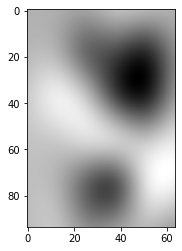

In [5]:
print(field.shape)
import matplotlib.pyplot as plt
plt.imshow(field[15, :, :, 0], cmap='gray')

(55, 93, 64, 3)


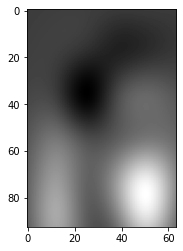

In [5]:
# Visualized the Displacement Field obtained from BSpline Transform

print(field.shape)
import matplotlib.pyplot as plt
plt.imshow(field[15, :, :, 0], cmap='gray')

In [3]:
# Visualize the results after RANSAC ICP

from itkwidgets import view

def readvtk(filename):
    a = vtk.vtkPolyDataReader()
    a.SetFileName(filename)
    a.Update()
    m1 = a.GetOutput()
    return m1

def readply(filename):
    a = vtk.vtkPLYReader()
    a.SetFileName(filename)
    a.Update()
    m1 = a.GetOutput()
    return m1

m1 = readvtk('/home/pranjal.sahu/Documents/SampleApeData/USNM174701-Cranium_merged_1.vtk')
#m2 = readvtk('/home/pranjal.sahu/Documents/SampleApeData/USNM174722-Cranium_1.vtk')
m2 = readvtk('ransacICPResult2_b_check.vtk')
#m3 = readvtk('ransacICPResult2_b_check.vtk')
m3 = readvtk('ransacICPResult2_c_check.vtk')


view(geometries=[m1, m2, m3])

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

In [ ]:
# TSD registration

imageDiagonal   = 50
stretchWeight   = 0.0001
bendWeight      = 0.0001
geometricWeight = 0.0001
maxStep         = 1
numOfIterations = 20
learningRate    = 1

movingMesh = itk.meshread('movingMesh.vtk', itk.D)
fixedMesh  = itk.meshread('fixedMesh.vtk', itk.D)

print('Number of Points are')
print(movingMesh.GetNumberOfPoints())
print(fixedMesh.GetNumberOfPoints())

fixedMesh.BuildCellLinks()
movingMesh.BuildCellLinks()

PixelType = itk.D
Dimension = 3

MeshType        = itk.Mesh[itk.D, Dimension]
FixedImageType  = itk.Image[PixelType, Dimension]

# For getting the Bounding Box
ElementIdentifierType = itk.UL
CoordType = itk.F
Dimension = 3

VecContType = itk.VectorContainer[
    ElementIdentifierType, itk.Point[CoordType, Dimension]
]
bounding_box = itk.BoundingBox[ElementIdentifierType, Dimension, CoordType, VecContType].New()
bounding_box.SetPoints(movingMesh.GetPoints())
bounding_box.ComputeBoundingBox()

minBounds = np.array(bounding_box.GetMinimum())
maxBounds = np.array(bounding_box.GetMaximum())


spacing = np.sqrt(bounding_box.GetDiagonalLength2()) / imageDiagonal
diff = maxBounds - minBounds

print('Spacing ', spacing)
print('minBounds ', minBounds)
print('maxBounds ', maxBounds)

fixedImageSize    = [0]*3
fixedImageSize[0] = math.ceil( 1.2 * diff[0] / spacing )
fixedImageSize[1] = math.ceil( 1.2 * diff[1] / spacing )
fixedImageSize[2] = math.ceil( 1.2 * diff[2] / spacing )

fixedImageOrigin    = [0]*3
fixedImageOrigin[0] = minBounds[0] - 0.1 * diff[0]
fixedImageOrigin[1] = minBounds[1] - 0.1 * diff[1]
fixedImageOrigin[2] = minBounds[2] - 0.1 * diff[2]

fixedImageSpacing   = np.ones(3)*spacing
fixedImageDirection = np.identity(3)


fixedImage = FixedImageType.New()
fixedImage.SetRegions(fixedImageSize)
fixedImage.SetOrigin( fixedImageOrigin )
fixedImage.SetDirection( fixedImageDirection )
fixedImage.SetSpacing( fixedImageSpacing )
fixedImage.Allocate()


# Create BSpline Transformation object and initialize the parameters
SplineOrder = 3
TransformType  = itk.BSplineTransform[itk.D, Dimension, SplineOrder]
InitializerType = itk.BSplineTransformInitializer[TransformType, FixedImageType]

transform = TransformType.New()

# Higher the grid dimensio, slower the computation but higher will be the accuracy
numberOfGridNodesInOneDimension = 8
transformInitializer = InitializerType.New()
transformInitializer.SetTransform(transform)
transformInitializer.SetImage(fixedImage)
transformInitializer.SetTransformDomainMeshSize(numberOfGridNodesInOneDimension - SplineOrder)
transformInitializer.InitializeTransform()



MetricType = itk.ThinShellDemonsMetricv4.MD3
metric = MetricType.New()
metric.SetStretchWeight(stretchWeight)
metric.SetBendWeight(bendWeight)
metric.SetGeometricFeatureWeight(geometricWeight)
metric.UseConfidenceWeightingOn()
metric.UseMaximalDistanceConfidenceSigmaOff()
metric.UpdateFeatureMatchingAtEachIterationOn()
metric.SetMovingTransform(transform)
# Reversed due to using points instead of an image
# to keep semantics the same as in itkThinShellDemonsTest.cxx
# For the ThinShellDemonsMetricv4 the fixed mesh is regularized
metric.SetFixedPointSet(movingMesh)
metric.SetMovingPointSet(fixedMesh)
metric.SetVirtualDomainFromImage(fixedImage)
metric.Initialize()

print('TSD Metric Created')


optimizer = itk.RegularStepGradientDescentOptimizerv4.D.New()
optimizer.SetNumberOfIterations( numOfIterations )
optimizer.SetMaximumStepSizeInPhysicalUnits( maxStep )
optimizer.SetLearningRate(learningRate)
optimizer.SetMinimumConvergenceValue( 0.0 )
optimizer.SetConvergenceWindowSize( numOfIterations )

def iteration_update():
    metric_value = optimizer.GetValue()
    current_parameters = optimizer.GetCurrentPosition()
    print(f"Metric: {metric_value:.8g}")

iteration_command = itk.PyCommand.New()
iteration_command.SetCommandCallable(iteration_update)
optimizer.AddObserver(itk.IterationEvent(), iteration_command)


print('Number of Transform Parameters ', transform.GetNumberOfParameters())

AffineRegistrationType = itk.ImageRegistrationMethodv4.REGv4D3D3TD3D3MD3.New()
registration = AffineRegistrationType.New()
registration.SetNumberOfLevels(1)
registration.SetObjectName("registration")
registration.SetFixedPointSet(movingMesh)
registration.SetMovingPointSet(fixedMesh)
registration.SetInitialTransform(transform)
registration.SetMetric(metric)
registration.SetOptimizer(optimizer)
registration.InPlaceOn()

print('Registration Object created')
print('Initial Value of Metric ', metric.GetValue())

try:
    registration.Update()
except e:
    print('Error is ', e)

print('Final Value of TSD Metric ', metric.GetValue())


# Get the Displacement field from the BSpline Transform
finalTransform = registration.GetModifiableTransform()
convertFilter = itk.TransformToDisplacementFieldFilter.IVF33D.New()
convertFilter.SetTransform(finalTransform)
convertFilter.UseReferenceImageOn()
convertFilter.SetReferenceImage(fixedImage)
convertFilter.Update()
field = convertFilter.GetOutput()
field = np.array(field)
np.save('displacement_field.npy', field)

e_metric = itk.EuclideanDistancePointSetToPointSetMetricv4.PSD3.New()
e_metric.SetFixedPointSet(fixedMesh)
e_metric.SetMovingPointSet(movingMesh)
print('Euclidean Metric Before TSD Deformable Registration ', e_metric.GetValue())

numberOfPoints = movingMesh.GetNumberOfPoints()
for n in range(0, numberOfPoints):
    movingMesh.SetPoint(n, finalTransform.TransformPoint(movingMesh.GetPoint(n)))

e_metric = itk.EuclideanDistancePointSetToPointSetMetricv4.PSD3.New()
e_metric.SetFixedPointSet(fixedMesh)
e_metric.SetMovingPointSet(movingMesh)
print('Euclidean Metric After TSD Deformable Registration ', e_metric.GetValue())

itk.meshwrite(movingMesh, 'result_bspline.vtk')

In [ ]:
# Visualize the fixed mesh, moving mesh and the registered mesh

a = vtk.vtkPolyDataReader()
a.SetFileName('ransacICPResult2.vtk')
a.Update()
m1 = a.GetOutput()

a = vtk.vtkPolyDataReader()
a.SetFileName('result_bspline.vtk')
a.Update()
m2 = a.GetOutput()

a = vtk.vtkPolyDataReader()
a.SetFileName('fixedMesh.vtk')
a.Update()
m3 = a.GetOutput()

itkwidgets.view(geometries=[m1, m2, m3])

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

In [4]:
#finalTransform = registration.GetModifiableTransform()
convertFilter = itk.TransformToDisplacementFieldFilter.IVF33D.New()
convertFilter.SetTransform(final_transform)
convertFilter.UseReferenceImageOn()
convertFilter.SetReferenceImage(fixedImage)
convertFilter.Update()
field = convertFilter.GetOutput()
field = np.array(field)
np.save('displacement_field.npy', field)

NameError: name 'final_transform' is not defined

(24, 48, 29, 3)


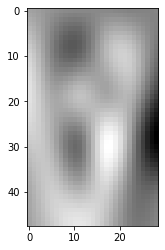

In [36]:
# Visualized the Displacement Field obtained from BSpline Transform

print(field.shape)
import matplotlib.pyplot as plt
plt.imshow(field[15, :, :, 0], cmap='gray')